In [1]:
import time
import matplotlib.pyplot as plt

try:
    from lattice_field_mcmc import ScalarPhi4Model2D
except ModuleNotFoundError:
    !git clone https://github.com/ToelUl/Lattice-Field-MCMC-GPU.git
    !cp -r Lattice-Field-MCMC-GPU/lattice_field_mcmc ./
    from lattice_field_mcmc import ScalarPhi4Model2D

import torch

if not torch.cuda.is_available():
    print("⚠️ GPU runtime is not enabled. Please go to 'Runtime' > 'Change runtime type' and set 'Hardware accelerator' to 'GPU'.")
else:
    print("✅ GPU runtime is enabled and ready!")

✅ GPU runtime is enabled and ready!


In [2]:
L_size = 32
kappas = torch.linspace(0.22, 0.3, 64)
lambda_val = 0.02
chains = 10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

phi4_sampler = ScalarPhi4Model2D(
    L=L_size,
    kappa=kappas.to(device),
    lambda_=lambda_val,
    n_chains=chains,
    proposal_width=0.4,
    target_acceptance_rate=0.5,
    tune_interval=50,
    tuning_strength=0.2,
    device=device,
    use_amp=True,
    pt_enabled=True
)

start = time.time()
samples = phi4_sampler.forward(
    n_sweeps=3000,
    n_therm=10000,
    decorrelate=10,
    pt_interval=2
)
end = time.time()

print(f"Simulation complete. Sample tensor shape: {samples.shape}")
print(f"Elapsed time: {end - start:.2f} seconds")

Initialized ScalarLatticeSampler2D on device: cuda
 L=32, BatchSize=64, ChainsPerKappa=10, AMP=True, PT=True, LargeSim=False
Proposal width tuning enabled: target_rate=0.5, interval=50
Starting simulation: 10000 thermalization sweeps, 3000 production sweeps.
Proposal width tuning is ENABLED.
  [Tuning] Avg Acc Rate: 0.929 -> Avg Proposal Width: 0.434
  [Tuning] Avg Acc Rate: 0.935 -> Avg Proposal Width: 0.472
  [Tuning] Avg Acc Rate: 0.932 -> Avg Proposal Width: 0.513
  [Tuning] Avg Acc Rate: 0.927 -> Avg Proposal Width: 0.557
  [Tuning] Avg Acc Rate: 0.921 -> Avg Proposal Width: 0.604
  [Tuning] Avg Acc Rate: 0.914 -> Avg Proposal Width: 0.654
  [Tuning] Avg Acc Rate: 0.906 -> Avg Proposal Width: 0.707
  [Tuning] Avg Acc Rate: 0.899 -> Avg Proposal Width: 0.763
  [Tuning] Avg Acc Rate: 0.891 -> Avg Proposal Width: 0.823
  [Tuning] Avg Acc Rate: 0.882 -> Avg Proposal Width: 0.885
  [Tuning] Avg Acc Rate: 0.873 -> Avg Proposal Width: 0.951
  [Tuning] Avg Acc Rate: 0.863 -> Avg Proposal 

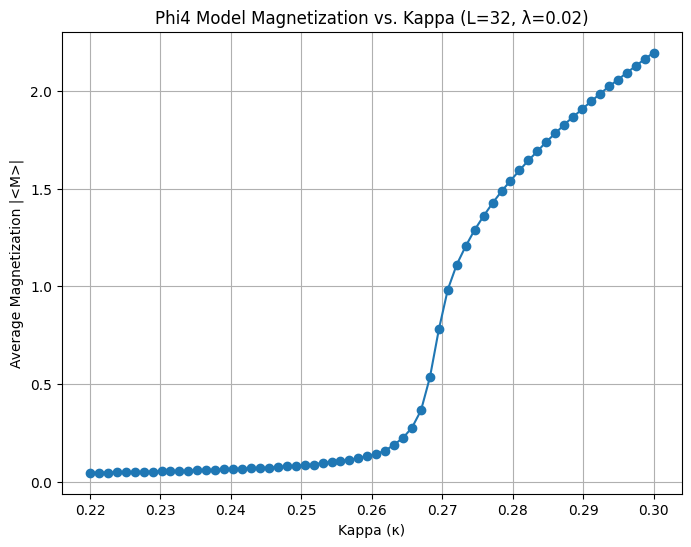

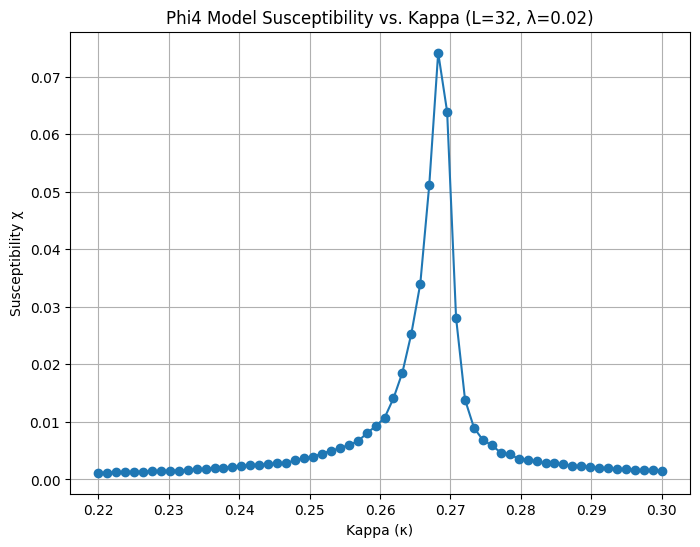

In [3]:
magnetization = samples.mean(dim=(-1, -2))
chi = torch.abs(magnetization).var(dim=1).cpu().numpy()
avg_magnetization_per_kappa = torch.abs(magnetization).mean(dim=1).cpu().numpy() # 在鏈和樣本維度上平均絕對值

plt.figure(figsize=(8, 6))
plt.plot(kappas.cpu().numpy(), avg_magnetization_per_kappa, 'o-')
plt.xlabel("Kappa (κ)")
plt.ylabel("Average Magnetization |<M>|")
plt.title(f"Phi4 Model Magnetization vs. Kappa (L={L_size}, λ={lambda_val})")
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(kappas.cpu().numpy(), chi, 'o-')
plt.xlabel("Kappa (κ)")
plt.ylabel("Susceptibility χ")
plt.title(f"Phi4 Model Susceptibility vs. Kappa (L={L_size}, λ={lambda_val})")
plt.grid(True)
plt.show()